### Install Dependencies

We install:
- `google-genai` to access Gemini models
- `gradio` for the chatbot UI
- `textblob` for sentiment analysis
- `pandas` & `matplotlib` for logging and analytics


In [1]:
# Install dependencies
!pip install -q -U google-genai gradio textblob pandas matplotlib
!python -m textblob.download_corpora


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2

### Import Libraries & Configure Gemini API

Import required modules and configure the Gemini API key, which is securely stored under "Gemini" in Colab secrets.


In [2]:
import os
import requests
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from google import genai

# Load Gemini API key from Colab secrets (named "Gemini")
from google.colab import userdata
api_key = userdata.get("Gemini")
if not api_key:
    raise ValueError("Gemini API key not found. Please add it under the name 'Gemini' in Colab secrets.")
client = genai.Client(api_key=api_key)


## Download & Chunk Self-Help Books (RAG)

We fetch three relationship/self-help text files from GitHub. Then split each into ~400-character chunks for retrieval.


In [3]:
# GitHub URLs (raw) for your books
BOOK_URLS = {
    "MarsVenus": "https://raw.githubusercontent.com/svvd-m/relationship-advice-chatbot/main/Men%20Are%20from%20Mars%20Women%20Are%20from%20Venus.txt",
    "Nonviolent": "https://raw.githubusercontent.com/svvd-m/relationship-advice-chatbot/main/Nonviolent%20Communication.txt",
    "ArtOfLoving": "https://raw.githubusercontent.com/svvd-m/relationship-advice-chatbot/main/The%20Art%20of%20Loving.txt"
}

# Download and chunk
rag_chunks = []
for title, url in BOOK_URLS.items():
    text = requests.get(url).text
    for i in range(0, len(text), 400):
        chunk = text[i:i+400].strip()
        if len(chunk) > 50:
            rag_chunks.append(f"[{title}] {chunk}")

print(f"✅ Loaded {len(rag_chunks)} chunks for RAG.")


✅ Loaded 3001 chunks for RAG.


## Sentiment Analysis

This function uses TextBlob to classify each user message as Positive, Negative, or Neutral.


In [4]:
def get_sentiment(text: str) -> str:
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.2:
        return "Positive"
    elif polarity < -0.2:
        return "Negative"
    else:
        return "Neutral"


## Chatbot Response Function

1. **RAG Retrieval:** Pull the top 3 chunks from `rag_chunks`.  
2. **Build Prompt:** Combine retrieved chunks and user prompt.  
3. **Gemini API Call:** Use `client.models.generate_content` with `"gemini-2.0-flash"`.  
4. **Sentiment & Logging:** Analyze tone, append to `chat_log.csv`.  
5. **Return:** Update Gradio chat history in `type="messages"` format.


In [5]:
# Ensure logs folder exists
os.makedirs("logs", exist_ok=True)
LOG_FILE = "logs/chat_log.csv"

def chatbot_response(user_message: str, chat_history: list[dict]):
    try:
        # 1. Retrieve RAG context (first 3 chunks for simplicity)
        retrieved = "\n\n".join(rag_chunks[:3])

        # 2. Build the combined prompt
        final_prompt = (
            "You are a psychologist specializing in relationship advice.\n"
            "Use these book excerpts as context:\n\n"
            f"{retrieved}\n\n"
            f"User: {user_message}\n"
            "Assistant:"
        )

        # 3. Call Gemini API (gemini-2.0-flash)
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=final_prompt
        )
        bot_reply = response.text.strip()

        # 4. Sentiment analysis and logging
        sentiment = get_sentiment(user_message)
        log_entry = pd.DataFrame([{
            "User Message": user_message,
            "Sentiment": sentiment,
            "Bot Response": bot_reply
        }])
        log_entry.to_csv(LOG_FILE, mode='a', header=not os.path.exists(LOG_FILE), index=False)

        # 5. Update chat history with new messages (matches type="messages")
        chat_history.append({"role": "user", "content": user_message})
        chat_history.append({"role": "assistant", "content": bot_reply})

        return chat_history, ""
    except Exception as e:
        # On error, show the error in the chat window
        chat_history.append({"role": "assistant", "content": f"API Error: {e}"})
        return chat_history, ""


## Clear Chat Function

Resets the conversation state and clears the chat window.


In [6]:
def clear_chat():
    return [], ""


## Gradio Chat Interface

- `type="messages"` uses OpenAI-style `{"role":"user"/"assistant","content":...}`.  
- **Enter** submits the message.  
- **Send** button also triggers the response.  
- **Clear** resets the chat.


In [7]:
with gr.Blocks() as app:
    gr.Markdown("## 💬 Relationship Advice Chatbot (Gemini + RAG + Sentiment)")
    gr.Markdown("Get expert relationship advice using AI trained on psychology books and sentiment analysis.")

    chatbot = gr.Chatbot(type="messages", label="Your Relationship Advisor")
    msg = gr.Textbox(placeholder="Type your message and press Enter...", label="Your Message", lines=1)
    send_btn = gr.Button("Send")
    clear_btn = gr.Button("Clear Chat")

    state = gr.State([])

    # Enter key triggers response
    msg.submit(fn=chatbot_response, inputs=[msg, state], outputs=[chatbot, msg])
    # Send button triggers response
    send_btn.click(fn=chatbot_response, inputs=[msg, state], outputs=[chatbot, msg])
    # Clear button resets the conversation
    clear_btn.click(fn=clear_chat, outputs=[chatbot, msg])

app.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ecaf1ccc330ecc233d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## How to Run the Analytics Dashboard

After you’ve finished interacting with the chatbot, follow these steps to view your chat logs and sentiment analytics:

1. **Stop the Gradio Chat Cell**
   - In Google Colab, locate the cell running the Gradio interface (it will show a “Busy” or spinning icon on the left).  
   - Click the ■ (Stop) button next to that cell’s execution indicator (e.g. “In [   ]”).  
   - Alternatively, you can choose **Runtime → Interrupt execution** from the menu.  
   - Once stopped, the Gradio cell will no longer be “busy,” and you can run subsequent cells.

2. **Run the Analytics Code Cell**
   - Directly below the Gradio cell, you will see the “Analytics Dashboard” code.  
   - Click inside that cell and press ▶️ (Run).  
   - The code will:
     1. Load the `logs/chat_log.csv` file created during your chat session.  
     2. Plot a bar chart showing how many messages were classified as Positive, Neutral, or Negative.  
     3. (Optional) Generate and display a word cloud of the most common words in all user messages.

3. **Review the Results**
   - A bar chart will appear, showing the distribution of sentiment in your logged conversations.  
   - If there are enough user messages, you’ll also see a word cloud highlighting frequently used terms.

4. **Troubleshooting**
   - If you see the message “No chat_log.csv found,” it means either:
     - You haven’t chatted yet, or  
     - You didn’t stop the Gradio cell before running this analytics cell.  
   - In that case, go back, run the Gradio cell, interact at least once, stop it, and then run the analytics cell again.

By following these steps, you can seamlessly transition from **chatting with the AI** to **analyzing your data**—all within the same Colab notebook.

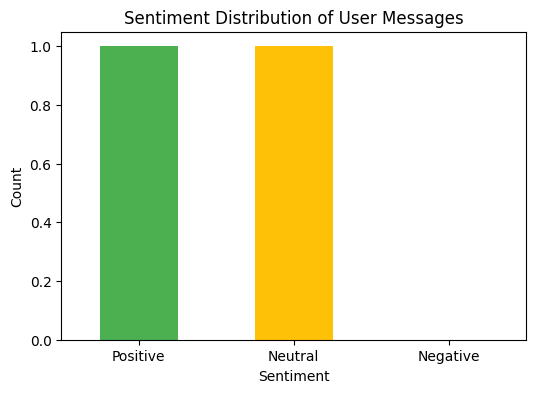

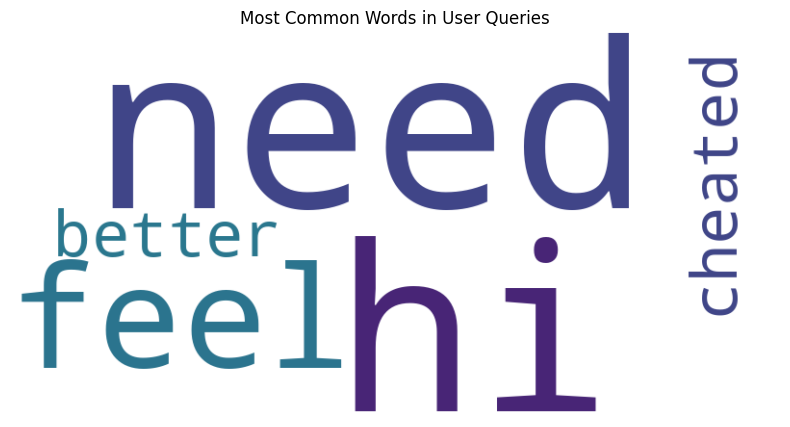

In [9]:
# -----------------------------------------------
# 📈 Analytics Dashboard Code Cell
# -----------------------------------------------

import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. Check that the log file exists
log_path = "logs/chat_log.csv"
if not os.path.exists(log_path):
    print("No chat_log.csv found. Run and stop the Gradio cell first to generate logs.")
else:
    # 2. Load the chat log into a DataFrame
    logs = pd.read_csv(log_path)

    # 3. Plot sentiment distribution
    plt.figure(figsize=(6, 4))
    sentiment_counts = logs["Sentiment"].value_counts().reindex(
        ["Positive", "Neutral", "Negative"], fill_value=0
    )
    sentiment_counts.plot(
        kind="bar",
        color=["#4CAF50", "#FFC107", "#F44336"]
    )
    plt.title("Sentiment Distribution of User Messages")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

    # 4. (Optional) Word Cloud of User Messages
    all_text = " ".join(logs["User Message"].dropna().astype(str).tolist())
    if len(all_text) > 0:
        wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title("Most Common Words in User Queries")
        plt.show()
    else:
        print("Not enough user messages to build a word cloud.")
